In [139]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
pd.set_option('display.max_rows',15)

In [140]:
# ---------------------- Load data ------------------------

In [141]:
# load bitcoin scaled data
bitcoin_scale = pd.read_csv ('/home/sunny/NWU/EECS349/Bitcoin_Price_Predictor/data/bitcoin_price_scaled.csv', \
                       parse_dates = True, index_col = [0])

In [142]:
# check data
bitcoin_scale

,Open,Volume,Market Cap,Close
0,-0.465778,-0.302261,-0.455671,-0.464142
1,-0.464861,-0.302261,-0.455057,-0.465361
2,-0.463872,-0.302261,-0.454395,-0.465631
3,-0.464031,-0.302261,-0.454491,-0.464932
4,-0.464559,-0.302261,-0.454831,-0.465236
5,-0.464175,-0.302261,-0.454567,-0.463707
6,-0.464037,-0.302261,-0.454467,-0.464369
...,...,...,...,...
1746,2.439860,1.927741,2.464486,2.701065
1747,2.436451,2.248272,2.461413,2.927780


In [143]:
# --------------------- Data preparation ---------------------

In [144]:
bitcoin_scale = np.array(bitcoin_scale)
# split data into training set and testing set
split = int(0.9 * bitcoin_scale.shape[0])
train_data = bitcoin_scale[0 : split]
test_data = bitcoin_scale[split : ]

In [145]:
bitcoin_scale

array([[-0.46577845, -0.3022605 , -0.45567105, -0.46414242],
       [-0.464861  , -0.3022605 , -0.45505719, -0.46536076],
       [-0.46387174, -0.3022605 , -0.45439541, -0.46563075],
       ...,
       [ 2.87832864,  2.66695596,  2.90484212,  3.0578475 ],
       [ 3.08825825,  2.77553342,  3.11543391,  3.28514582],
       [ 3.09575298,  2.62899335,  3.12334792,  3.34535372]])

In [146]:
# extract input and output training set
# input set: 1584 x 3 matrix
x_train = train_data[:, [0, 1, 2]]
# output set: 1584 x 1 matrix
y_train = train_data[:, 3]

# extract input and output testing set
# input set: 176 x 3 matrix
x_test = test_data[:, [0, 1, 2]]
# output set: 176 x 1 matrix
y_test = test_data[:, 1]

# check dataset
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1577, 3) (1577,) (176, 3) (176,)


In [147]:
# --------------------- Build neural network -------------------

In [148]:
# set number of datasets (columns)
n_dataset = x_train.shape[1]

# set number of neurons in each layer
n_neurons_1 = 4
n_neurons_2 = 2
n_target = 1

In [149]:
# session
net = tf.InteractiveSession()

/home/sunny/.conda/envs/py3env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [150]:
# define input and output placeholder for neural network
# The None argument indicates that at this point we do not yet know the number of 
# observations that flow through the neural net graph in each batch
X = tf.placeholder(dtype = tf.float32, name = "X", shape = [None, n_dataset])
Y = tf.placeholder(dtype = tf.float32, name = "Y", shape = [None])

In [151]:
# define initializer
sigma = 1.0
weight_initializer = tf.variance_scaling_initializer(mode = "fan_avg", distribution = "uniform", scale = sigma)
bias_initializer = tf.zeros_initializer()

In [152]:
# model architecture parameter
# hidden layers + bias

# Layer 1: Variables for hidden weights and biases
w_hidden_1 = tf.Variable(weight_initializer([n_dataset, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

# Layer 2: Variables for hidden weights and biases
w_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

# Output Layer:
w_out = tf.Variable(weight_initializer([n_neurons_2, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

In [153]:
# activation function (ReLU) for each hidden layer

# activation function for hidden layer 1
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, w_hidden_1), bias_hidden_1))

# activation function for hidden layer 2
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, w_hidden_2), bias_hidden_2))

# output layer
out = tf.transpose(tf.add(tf.matmul(hidden_2, w_out), bias_out))

In [154]:
# define cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

In [155]:
# define optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

In [156]:
# initialize all variables above
net.run(tf.global_variables_initializer())

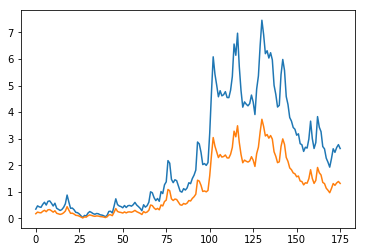

In [157]:
# set up plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

In [158]:
# fit neural net
batch_size = 15
epochs = 10

mse_train = []
mse_test = []

for e in range(epochs):
    
    # shuffle the data first
    shuffle_indices = np.random.permutation(np.arange(0, len(y_train)))
    x_train = x_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    # mini-batch training
    for i in range(len(y_train) // batch_size):
        start = i * batch_size
        batch_x = x_train[start : start + batch_size]
        batch_y = y_train[start : start + batch_size]
        
        # run optimizer with batch
        net.run(opt, feed_dict = {X: batch_x, Y: batch_y})
        
        # show progress
        if np.mod(i , 50) == 0:
            
            # mse training and testing
            mse_train.append(net.run(mse, feed_dict = {X: batch_x, Y: batch_y}))
            mse_test.append(net.run(mse, feed_dict = {X: x_test, Y: y_test}))
        
        # prediction
        pred = net.run(out, feed_dict = {X: x_test})
        

The mean squared errors are [9.203902, 9.383635, 9.296914, 9.201968, 7.9900665, 6.4253902, 6.238588, 4.7395277, 3.5001137, 3.3456068, 2.2149534, 1.6726626, 1.6109494, 1.2360569, 1.0192227, 0.9854799, 0.8716848, 0.69980586, 0.697528, 0.6785517, 0.65418655, 0.6617621, 0.65328884, 0.64349836, 0.6622309, 0.6207732, 0.70308954, 0.706138, 0.6622706, 0.7398028]


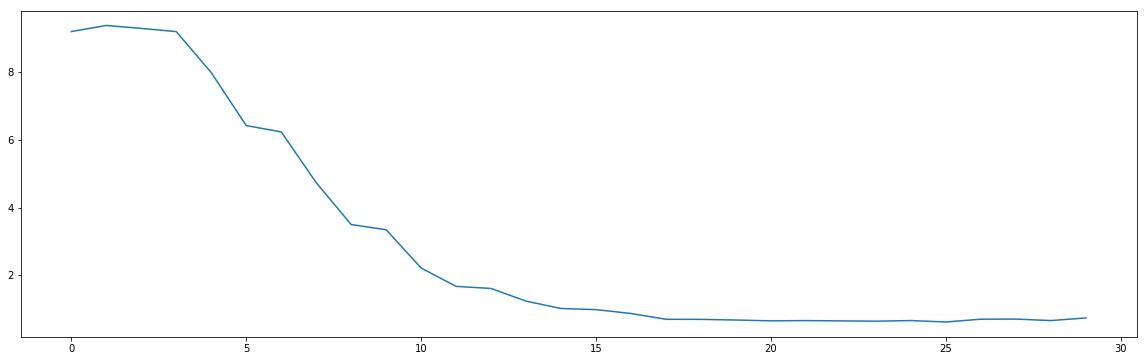

In [159]:
# plot learning curve
plt.figure(figsize = (20, 6))
plt.plot(mse_test)
plt.show

print("The mean squared errors are", str(mse_test))

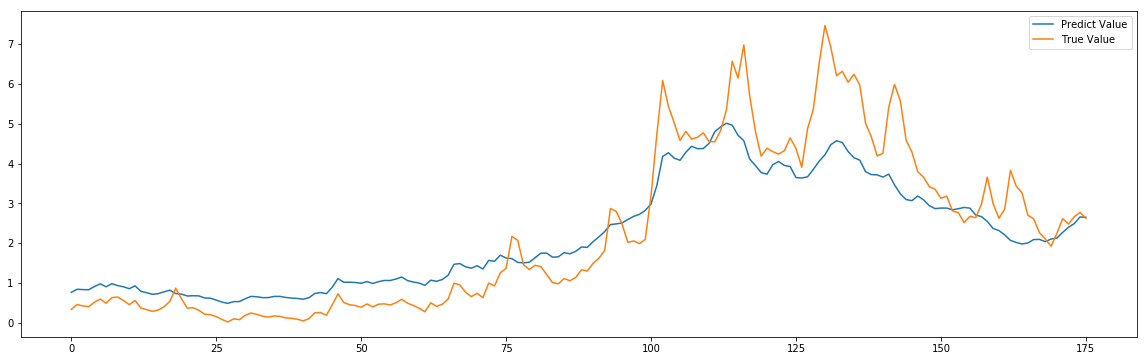

In [160]:
# plot the prediction values and true values
plt.figure(figsize = (20, 6))
plt.plot(pred[0], label = 'Predict Value')
plt.plot(y_test, label = 'True Value')
plt.legend(loc = 'best')
plt.show()

In [161]:
pred

array([[0.77457047, 0.8499248 , 0.8422744 , 0.8383732 , 0.91867757,
        0.9871056 , 0.9119568 , 0.98943293, 0.94165885, 0.9132663 ,
        0.8651322 , 0.93498313, 0.79863906, 0.763216  , 0.72344124,
        0.7409202 , 0.78599775, 0.82693744, 0.74413204, 0.7289132 ,
        0.6824781 , 0.68743503, 0.68378234, 0.6318836 , 0.6261116 ,
        0.57864416, 0.52766335, 0.4974437 , 0.5394198 , 0.5425627 ,
        0.6120517 , 0.6717824 , 0.66243887, 0.6401659 , 0.6420125 ,
        0.67088294, 0.6707009 , 0.6448338 , 0.630018  , 0.61985016,
        0.6004131 , 0.639403  , 0.7436837 , 0.7672851 , 0.73933995,
        0.8995042 , 1.1161213 , 1.0254143 , 1.0272992 , 1.0201383 ,
        1.0003916 , 1.0436949 , 0.99500656, 1.0413154 , 1.0711566 ,
        1.0698062 , 1.1069665 , 1.156889  , 1.0673718 , 1.0327896 ,
        1.0048133 , 0.94914925, 1.0776926 , 1.0495856 , 1.0953479 ,
        1.2027689 , 1.4756564 , 1.4948776 , 1.4138068 , 1.3783895 ,
        1.4410704 , 1.358315  , 1.5731854 , 1.55